# Tutorial for mvTCR

In this tutorial, we create an atlas for tumor-infiltrating lymphocytes (TIL). The dataset is collected by Borcherding and contains ~750,000 samples from 11 cancer types and 6 tissue sources. We use mvTCR to build the atlas and later integrate a heldout query into it. After the data integration, we use it to infer the cancer type from the heldout dataset using a simple kNN trained on the learned latent representation.

mvTCR is a multi-modal generative integration method for transcriptome and T-cell receptor (TCR) data. For more information on mvTCR please refer to [Drost 2022](https://www.biorxiv.org/content/10.1101/2021.06.24.449733v2.full.pdf)

## Download dataset
First we download the mvTCR package and the preprocessed Tumor-infiltrating Lymphocyte (TIL) dataset. The unpreprocessed dataset can be downloaded at https://github.com/ncborcherding/utility

In [1]:
!pip install mvtcr

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import gdown
import os
url = 'https://drive.google.com/uc?id=1Zt8G5wsLaPW6xhNFhh041i0oMAX68tgi'
output = 'borcherding.h5ad'
if not os.path.exists(output):
    gdown.download(url, output, quiet=False)

## Import libraries

In [3]:
import torch
import scanpy as sc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

In [4]:
import scarches as sca

/home/icb/yang.an/scarches/scarches/dataset/__init__.py:9: UserWarning: In order to use the mouse gastrulation seqFISH datsets, please install squidpy (see https://github.com/scverse/squidpy).
  warnings.warn('In order to use the mouse gastrulation seqFISH datsets, please install squidpy (see https://github.com/scverse/squidpy).')
/home/icb/yang.an/scarches/scarches/models/__init__.py:11: UserWarning: In order to use sagenet models, please install pytorch geometric (see https://pytorch-geometric.readthedocs.io) and 
 captum (see https://github.com/pytorch/captum).
  warnings.warn('In order to use sagenet models, please install pytorch geometric (see https://pytorch-geometric.readthedocs.io) and \n captum (see https://github.com/pytorch/captum).')
Global seed set to 0
/home/icb/yang.an/miniconda3/envs/scarches2/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecate

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
random_seed = 42
sca.models.mvTCR.utils_training.fix_seeds(random_seed)

## Set hyperparameters

Here the hyperparameters can be set

In [7]:
N = 100000  # number of subsamples

In [8]:
# We holdout two Cohorts out of 13
holdout_cohorts = ['GSE154826',
                   'GSE162500']

# maps each batch to an index, important is that the holdout cohorts are at the last positions
mapper = {'GSE123814': 0, 'GSE114724': 1, 'GSE139555': 2, 'GSE145370': 3,
          'GSE180268': 4, 'GSE176021': 5, 'GSE148190': 6, 'GSE159251': 7,
          'CCR-20-4394': 8, 'PRJNA705464': 9, 'GSE121636': 10, 'GSE154826': 11, 'GSE162500': 12}

In [9]:
# Parameters for model and training
params_architecture = {'batch_size': 512,
                       'learning_rate': 0.0006664047426647477,
                       'loss_weights': [1.0, 0.016182440457269676, 1.0110670042409596e-10],
                       'joint': {'activation': 'leakyrelu',
                                 'batch_norm': True,
                                 'dropout': 0.05,
                                 'hdim': 100,
                                 'losses': ['MSE', 'CE'],
                                 'num_layers': 2,
                                 'shared_hidden': [100, 100],
                                 'zdim': 50,
                                 'c_embedding_dim': 20,
                                 'use_embedding_for_cond': True,
                                 'num_conditional_labels': 11,
                                 'cond_dim': 20,
                                 'cond_input': True},
                       'rna': {'activation': 'leakyrelu',
                               'batch_norm': True,
                               'dropout': 0.05,
                               'gene_hidden': [500, 500, 500],
                               'num_layers': 3,
                               'output_activation': 'linear',
                               'xdim': 5000},
                       'tcr': {'embedding_size': 64,
                               'num_heads': 4,
                               'forward_expansion': 4,
                               'encoding_layers': 1,
                               'decoding_layers': 1,
                               'dropout': 0.25,
                               'max_tcr_length': 30,
                               'num_seq_labels': 24}
                      }

params_experiment = {
    'model_name': 'moe',
    'n_epochs': 200,
    'early_stop': 5,
    'balanced_sampling': 'clonotype',
    'kl_annealing_epochs': None,
    'metadata': ['clonotype', 'Sample', 'Type', 'Tissue', 'Tissue+Type', 'functional.cluster'],
    'save_path': 'saved_models',
    'conditional': 'Cohort'
}

params_optimization = {
    'name': 'pseudo_metric',
    'prediction_labels':
        {'clonotype': 1,
         'Tissue+Type': 10}
}

## Load Data
We load the data using scanpy and subsample N samples from the full dataset for this demo

In [10]:
adata = sc.read_h5ad('borcherding.h5ad')
adata.obs['Cohort_id'] = adata.obs['Cohort'].map(mapper)
adata.obs['Tissue+Type'] = [f'{tissue}.{type_}' for tissue, type_ in zip(adata.obs['Tissue'], adata.obs['Type'])]
metadata = ['Tissue', 'Type', 'Tissue+Type', 'functional.cluster', 'set', 'Cohort']

In [11]:
sc.pp.subsample(adata, n_obs=N)

## Train model on atlas dataset
The model is initialized and trained on the atlas dataset until convergence, for early stopping we subsample 20% from the training dataset as validation dataset

In [12]:
# Split data into training and hold-out dataset
adata.obs['set'] = 'train'
adata.obs['set'][adata.obs['Cohort'].isin(holdout_cohorts)] = 'hold_out'
adata.obsm['Cohort'] = torch.nn.functional.one_hot(torch.tensor(adata.obs['Cohort_id'])).numpy()

# Stratified splitting of training into train and val. The val set is used for early stopping
adata_train = adata[~adata.obs['Cohort'].isin(holdout_cohorts)].copy()
adata_train.obsm['Cohort'] = torch.nn.functional.one_hot(torch.tensor(adata_train.obs['Cohort_id'])).numpy()
train, val = sca.models.mvTCR.utils_preprocessing.group_shuffle_split(adata_train, group_col='clonotype', val_split=0.2, random_seed=random_seed)
adata_train.obs.loc[val.obs.index, 'set'] = 'val'

In [13]:
model = sca.models.mvTCR.models.mixture_modules.moe.MoEModel(adata_train, params_architecture, params_experiment['balanced_sampling'], params_experiment['metadata'],
                                                             params_experiment['conditional'], params_optimization)

In [14]:
model.train(params_experiment['n_epochs'], params_architecture['batch_size'], params_architecture['learning_rate'],
            params_architecture['loss_weights'], params_experiment['kl_annealing_epochs'],
            params_experiment['early_stop'], params_experiment['save_path'])

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 128/200 [47:04<26:28, 22.07s/it]

Early stopped


## Finetune model on query

To finetune the model, we load the pretrained model with best pseudo metric performance from the previous step. Then we initizalize additional embedding vectors for the query datasets and freeze all weights except the embedding layer, before further training on the query dataset

In [15]:
# Separate holdout data and create a validation set (20%) for early stopping
adata_hold_out = adata[adata.obs['Cohort'].isin(holdout_cohorts)].copy()
adata_hold_out.obsm['Cohort'] = torch.nn.functional.one_hot(torch.tensor(adata_hold_out.obs['Cohort_id'])).numpy()
train, val = sca.models.mvTCR.utils_preprocessing.group_shuffle_split(adata_hold_out, group_col='clonotype', val_split=0.2, random_seed=random_seed)
adata_hold_out.obs['set'] = 'train'
adata_hold_out.obs.loc[val.obs.index, 'set'] = 'val'

In [16]:
# Load pretrained model
model = sca.models.mvTCR.utils_training.load_model(adata_train, f'saved_models/best_model_by_metric.pt', base_path='.')
model.add_new_embeddings(len(holdout_cohorts))  # add new cond embeddings
model.freeze_all_weights_except_cond_embeddings()
model.change_adata(adata_hold_out)  # change the adata to finetune on the holdout data

In [17]:
# Finetune model
model.train(n_epochs=200, batch_size=params_architecture['batch_size'], learning_rate=params_architecture['learning_rate'], 
            loss_weights=params_architecture['loss_weights'], kl_annealing_epochs=None, early_stop=5, 
            save_path=f'saved_models/finetuning/', comet=None)

  3%|███████▎                                                                                                                                                                                                                                           | 6/200 [00:17<09:39,  2.99s/it]

Early stopped


## Get latent representation and visualize using UMAP

After finetuning, we take a first qualitative look on the latent representation by using UMAP to visualize them

In [18]:
model = sca.models.mvTCR.utils_training.load_model(adata_hold_out, f'saved_models/finetuning/best_model_by_metric.pt', base_path='.')

In [19]:
latent_adata = model.get_latent(adata, metadata=metadata, return_mean=True)

In [26]:
# For visualization purpose
latent_adata.obs['Cohort_held_out'] = latent_adata.obs['Cohort'].copy()
latent_adata.obs.loc[~latent_adata.obs['Cohort'].isin(holdout_cohorts), 'Cohort_held_out'] = None

In [20]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

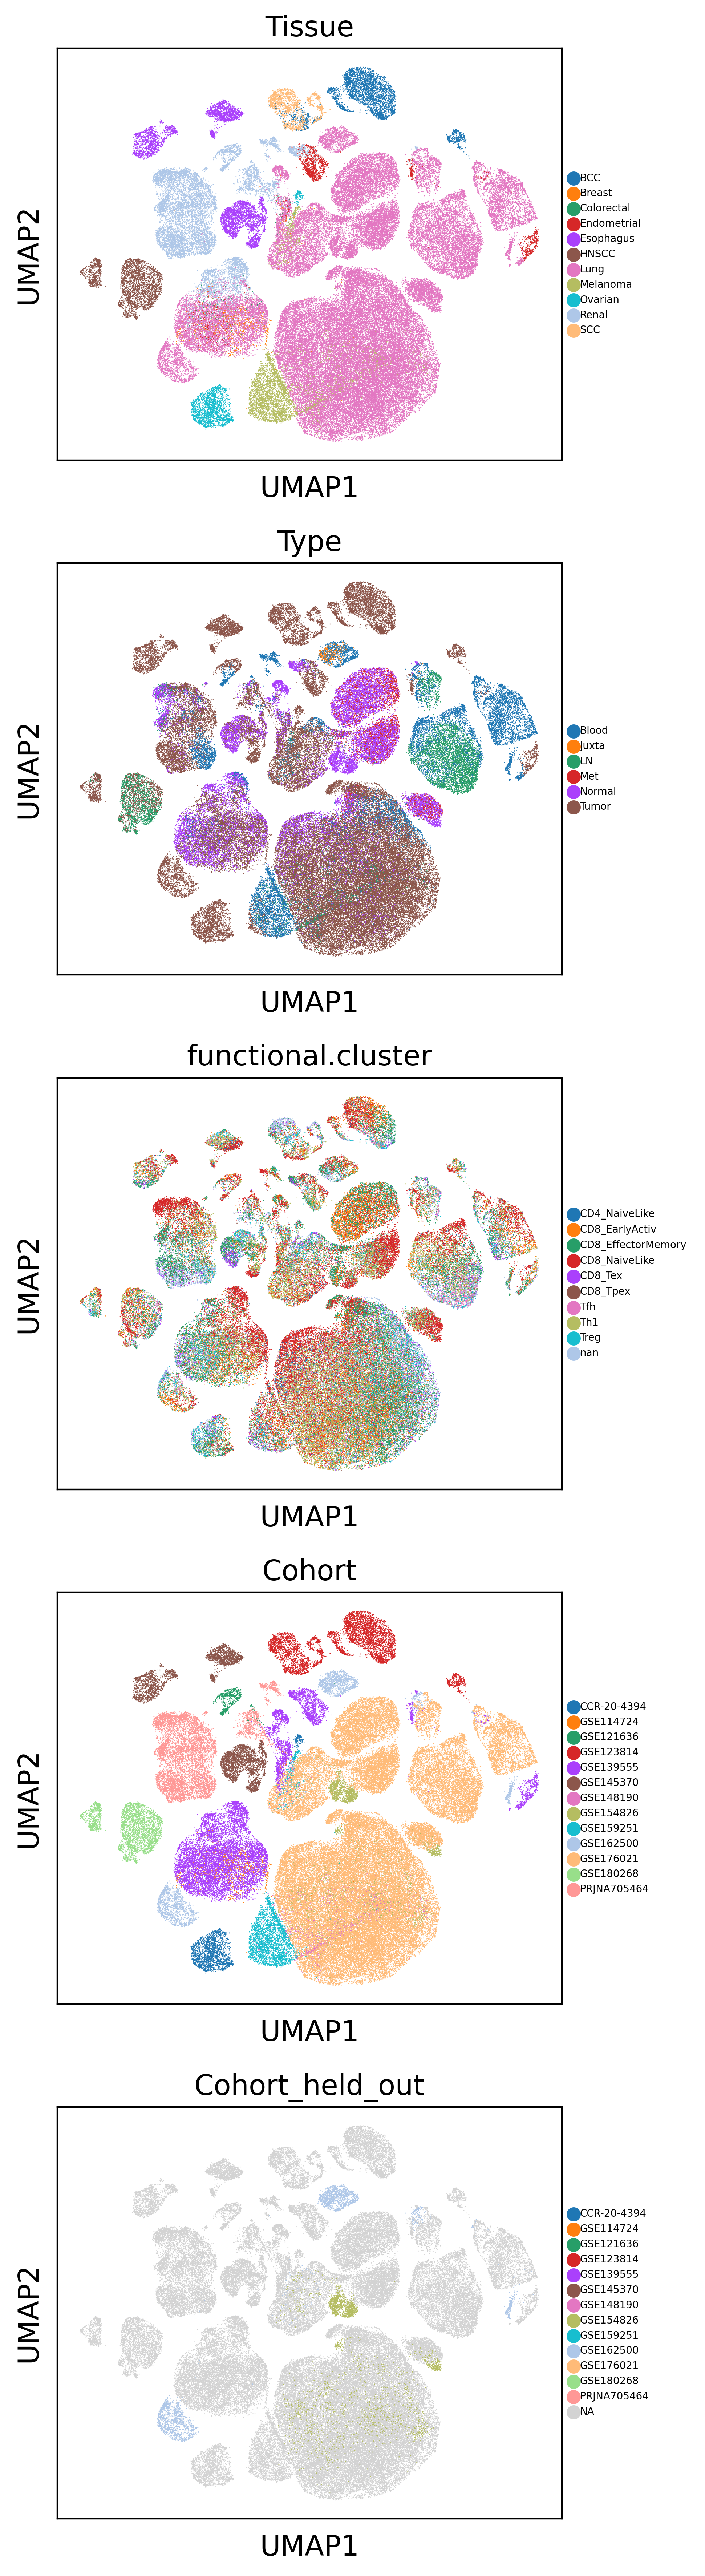

In [32]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (4, 4)
sc.pl.umap(latent_adata, color=['Tissue', 'Type', 'functional.cluster', 'Cohort', 'Cohort_held_out'], size=1, ncols=1, legend_fontsize=5)

## Use latent representation for downstream task
We can now use the latent representation for downstream tasks, such as clustering, analysis or imputation. In this example we show how to use a simple kNN classifier to predict the cancer type of the holdout data.

In [22]:
X_train = latent_adata[latent_adata.obs['set'] == 'train'].X
y_train = latent_adata[latent_adata.obs['set'] == 'train'].obs['Tissue']
X_test = latent_adata[latent_adata.obs['set'] == 'hold_out'].X
y_test = latent_adata[latent_adata.obs['set'] == 'hold_out'].obs['Tissue']

In [23]:
classifier = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [24]:
print(f'F1-score for Cancer Type Prediction: {f1_score(y_test, y_pred, average="weighted"):.3}')

F1-score for Cancer Type Prediction: 0.88
